<a href="https://colab.research.google.com/github/TAUforPython/machinelearning/blob/main/example%20Overlay%20dataset%20metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages (if not already available)
!pip install liac-arff --quiet # Uncomment if running in an environment where arff is not installed

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import math
import copy
from scipy.spatial.distance import cdist
from scipy.sparse.csgraph import minimum_spanning_tree
from sklearn.cluster import KMeans
import sklearn.metrics
from operator import itemgetter

  Preparing metadata (setup.py) ... done



* F1 (Maximum Fisher's discriminant ratio): Measures the discriminative power of individual features by comparing the separation of class means relative to their variances. Lower values indicate more overlap.
* F1v (Directional-vector Fisher's discriminant ratio): Extends F1 to consider the optimal projection direction that best separates the two classes, providing a single measure of linear separability.
* F2 (Overlapping region of per-class bounding boxes): Calculates the relative size of the overlapping area between the bounding hyper-boxes of the two classes. Higher overlap yields lower F2 values.
* F3 (Maximum individual feature efficiency): Identifies the single feature that provides the best (lowest) overlap between classes, indicating the minimum number of features needed for some separation.
* F4 (Collective feature efficiency): Estimates the number of features required to achieve class separation, considering the combined effect of all features. Lower values suggest higher redundancy or difficulty.
* R_value (Augmented R value): Assesses the local class overlap by looking at the neighborhoods of samples and calculating how often a class's neighbors belong to another class, adjusted for imbalance.
* D3_value (Decision stump boundary): Evaluates how well a simple one-level decision tree (decision stump) can separate the classes based on neighbor consistency.
* CM (Collective cost complexity): Related to kDN, it measures the overall classification difficulty by counting how many samples are in regions of high class disagreement.
* kDN (K-Dis agreement): Measures the average level of disagreement between a sample's class and its k-nearest neighbors, indicating how "noisy" or misclassified a point might be locally.
* MRCA (Multiresolution Class Association): Analyzes the local structure and class association at multiple scales (hypersphere radii) and clusters regions with similar characteristics.
* C1 (Error rate of 1-NN classifier): Estimates the error rate of a 1-Nearest Neighbor classifier by evaluating the local purity around each sample using hyperspheres.
* C2 (Error rate of 1-NN classifier, distance weighted): Similar to C1 but weights neighbors by their inverse distance, giving more importance to closer points when calculating local purity.
* T1 (Fraction of hyperspheres covering data): Measures the simplicity of the class boundary by determining how many hyperspheres (based on distances to nearest opposites) are needed to cover the data without significant overlap.
* DBC (Decision boundary complexity): Assesses the geometric complexity of the decision boundary by constructing a graph (MST) of hypersphere centers and counting edges that connect different classes.
* N1 (Fraction of borderline points): Uses the Minimum Spanning Tree of the data to find how many connections link samples of different classes, indicating boundary complexity.
* N2 (Ratio of average intra/inter class nearest neighbor distances): Compares the average distance to the nearest neighbor of the same class versus the nearest neighbor of a different class. Values closer to 0 indicate better separation.
* N3 (Error rate of NN classifier): Directly measures the leave-one-out error rate of the 1-Nearest Neighbor classifier.
* N4 (Non-linearity of NN classifier): Tests the non-linearity of the classification problem by evaluating how well the NN classifier performs on artificially generated (interpolated) samples.
* SI (Separability index): Measures the overall separability by calculating the percentage of samples that are correctly classified by their nearest neighbor.
* LSC (Local Set Average Cardinality): Evaluates class overlap by measuring the average number of same-class neighbors within the range defined by the distance to the nearest enemy (different class).
* purity: Partitions the feature space into a grid and calculates the average purity (dominance of one class) within each cell, integrated across different resolutions.
* neighbourhood_separability: Assesses how well classes are separated within local neighborhoods across different grid resolutions, focusing on the consistency of class labels among neighbors.
* input_noise (Potential class overlapping): Estimates the potential for class overlap by calculating the volume of the feature space where both classes' bounding boxes intersect.
* borderline: Calculates the percentage of samples that have a significant number of neighbors from the opposing class, identifying samples near the decision boundary.
* deg_overlap (Degree of class overlapping): Measures the overall extent of class overlap by determining how many samples have neighbors from the other class within their k-nearest neighbors.
* ICSV (Intra-class similarity variance): Quantifies the variance in the density of hyperspheres, indicating how uniform or varied the local structure of the classes is.
* NSG (Average number of samples per hypersphere): Measures the granularity of the class boundaries by calculating the average number of samples contained within each hypersphere.

Visualizing the generated and scaled dataset:


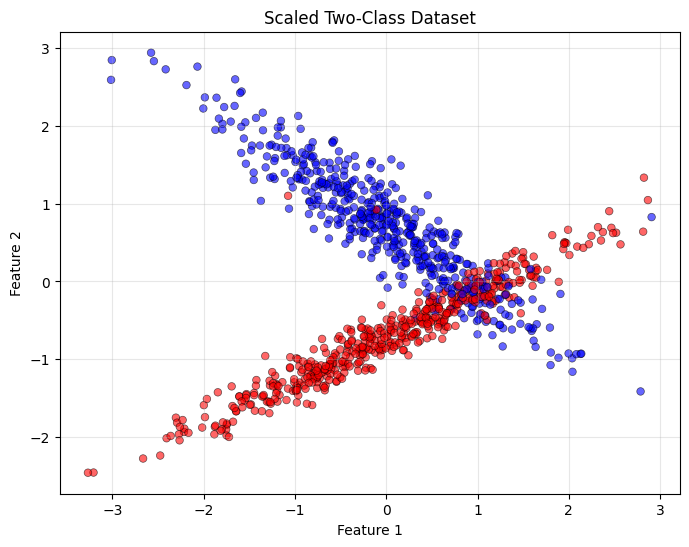

In [3]:
# --- Dataset Generation and Preprocessing ---
# Generate overlaid two-class dataset
X, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    n_clusters_per_class=1,
    class_sep=0.8,  # Controls class overlap - lower values increase overlap
    random_state=42
)

# Apply standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Visualization Function ---
def visualize_dataset(X, y, title="Dataset Visualization"):
    """Visualize the dataset with class colors."""
    plt.figure(figsize=(8, 6))
    colors = ['red' if label == 0 else 'blue' for label in y]
    plt.scatter(X[:, 0], X[:, 1], c=colors, alpha=0.6, s=30, edgecolors='k', linewidth=0.5)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.grid(True, alpha=0.3)
    plt.show()

# Visualize the scaled dataset
print("Visualizing the generated and scaled dataset:")
visualize_dataset(X_scaled, y, "Scaled Two-Class Dataset")

# --- Complexity Class (Adapted for Synthetic Data) ---
class SyntheticComplexity:
    """
    Calculates complexity metrics for a synthetic 2D, 2-class dataset.
    Adapted logic from the provided Complexity class for direct numpy array input.
    """
    def __init__(self, X, y):
        """
        Initializes the complexity calculator with data.
        X: 2D numpy array of features (n_samples, n_features)
        y: 1D numpy array of labels (n_samples,)
        """
        self.X = np.array(X)
        self.y = np.array(y)
        self.classes = np.unique(self.y) # Assumes 0 and 1 for two-class
        if len(self.classes) != 2:
             raise ValueError("This implementation is designed for two-class problems.")

        self.class_inxs = [np.where(self.y == self.classes[0])[0], np.where(self.y == self.classes[1])[0]]
        self.class_count = np.array([len(self.class_inxs[0]), len(self.class_inxs[1])])

        # Calculate Euclidean distance matrix
        self.dist_matrix = cdist(self.X, self.X, 'euclidean')
        # For T1-related measures, we might need the unnormalized distances too,
        # but for simplicity with Euclidean in 2D, we can use the same matrix.
        self.unnorm_dist_matrix = self.dist_matrix

    def __knn(self, inx, line, k, clear_diag=True):
        """Find k nearest neighbors counts for each class."""
        count = np.zeros(len(self.classes))
        if clear_diag:
            line[inx] = np.inf
        # Get indices of the k smallest distances
        nearest_inxs = np.argpartition(line, k)[:k]
        for idx in nearest_inxs:
            cls_inx = np.where(self.classes == self.y[idx])[0][0]
            count[cls_inx] += 1
        return count

    def __hypersphere(self, inx, sigma, distance_matrix=None, y=None):
        """Counts points inside a hypersphere."""
        if distance_matrix is None:
            distance_matrix = self.dist_matrix
        if y is None:
            y = self.y
        line = distance_matrix[inx]
        n_minus, n_plus = 0, 0
        for i in range(len(line)):
            if line[i] <= sigma:
                if y[i] == y[inx]:
                    n_plus += 1
                else:
                    n_minus += 1
        return [n_minus, n_plus]

    def __find_nearest_oposite_class_all(self, dist_matrix=None):
        """Find nearest opposite class sample for all points."""
        if dist_matrix is None:
            dist_matrix = self.dist_matrix
        nearest_oposite_class_array = []
        nearest_oposite_class_dist_array = []
        for i in range(len(dist_matrix)):
            min_dist = np.inf
            min_inx = None
            for j in range(len(dist_matrix[i])):
                if self.y[i] != self.y[j] and dist_matrix[i][j] < min_dist:
                    min_dist = dist_matrix[i][j]
                    min_inx = j
            nearest_oposite_class_array.append(min_inx)
            nearest_oposite_class_dist_array.append(min_dist)
        return np.array(nearest_oposite_class_array), np.array(nearest_oposite_class_dist_array)

    def __find_spheres(self, ind, e_ind, e_dist, radius):
        """Recursive function to calculate T1 hypersphere radii."""
        if radius[ind] >= 0.0:
            return radius[ind]
        ind_enemy = e_ind[ind]
        if ind == e_ind[ind_enemy]:
            radius[ind_enemy] = 0.5 * e_dist[ind]
            radius[ind] = 0.5 * e_dist[ind]
            return radius[ind]
        radius[ind] = 0.0
        radius_enemy = self.__find_spheres(ind_enemy, e_ind, e_dist, radius)
        radius[ind] = abs(e_dist[ind] - radius_enemy)
        return radius[ind]

    def __remove_overlapped_spheres(self, radius):
        """Remove overlapped spheres for T1-based measures."""
        inx_sorted = np.argsort(radius)
        inst_per_sphere = np.ones(len(self.X), dtype=int)
        for inx1, inx1_sphere in enumerate(inx_sorted[:-1]):
            for inx2_sphere in inx_sorted[:inx1:-1]:
                center_a, center_b = self.X[inx1_sphere], self.X[inx2_sphere]
                radius_a, radius_b = radius[inx1_sphere], radius[inx2_sphere]
                if np.sum((center_a - center_b)**2) < (radius_b - radius_a)**2:
                    inst_per_sphere[inx2_sphere] += inst_per_sphere[inx1_sphere]
                    inst_per_sphere[inx1_sphere] = 0
                    break
        return inst_per_sphere

    def __get_sphere_count(self):
        """Get sphere counts and radii for T1-based measures."""
        e_ind, e_dist = self.__find_nearest_oposite_class_all(dist_matrix=self.unnorm_dist_matrix)
        radius = np.array([-1.0] * len(e_ind))
        for ind in range(len(radius)):
            if radius[ind] < 0.0:
                self.__find_spheres(ind, e_ind, e_dist, radius)
        sphere_inst_count = self.__remove_overlapped_spheres(radius)
        return sphere_inst_count, radius

    # --- Complexity Metrics ---

    # 1. F1: Maximum Fisher's discriminant ratio for features (One vs One)
    # Measures the overlap of feature distributions between classes.
    def F1(self):
        """F1: Maximum Fisher's discriminant ratio (per feature)."""
        sample_c1 = self.X[self.class_inxs[0]]
        sample_c2 = self.X[self.class_inxs[1]]
        avg_c1 = np.mean(sample_c1, axis=0)
        avg_c2 = np.mean(sample_c2, axis=0)
        std_c1 = np.std(sample_c1, axis=0)
        std_c2 = np.std(sample_c2, axis=0)
        # Prevent division by zero
        denominator = std_c1**2 + std_c2**2
        denominator = np.where(denominator == 0, 1e-10, denominator)
        f1 = ((avg_c1 - avg_c2) ** 2) / denominator
        f1 = 1 / (1 + f1)
        return f1 # Returns value for each feature

    # 2. F1v: Directional-vector Fisher's discriminant ratio (One vs One)
    # Measures class separability along the optimal projection vector.
    def F1v(self):
        """F1v: Directional-vector Fisher's discriminant ratio."""
        sample_c1 = self.X[self.class_inxs[0]]
        sample_c2 = self.X[self.class_inxs[1]]
        avg_c1 = np.mean(sample_c1, axis=0)
        avg_c2 = np.mean(sample_c2, axis=0)
        # Within-class scatter matrix
        cov_c1 = np.cov(sample_c1, rowvar=False)
        cov_c2 = np.cov(sample_c2, rowvar=False)
        W = (len(sample_c1) * cov_c1 + len(sample_c2) * cov_c2) / (len(sample_c1) + len(sample_c2))
        # Between-class scatter matrix
        diff = (avg_c1 - avg_c2).reshape(-1, 1)
        B = np.dot(diff, diff.T)

        # Compute the discriminant vector
        try:
            W_inv = np.linalg.pinv(W)
            d = np.dot(W_inv, (avg_c1 - avg_c2))
            # Calculate the ratio
            numerator = np.dot(np.dot(d.T, B), d)
            denominator = np.dot(np.dot(d.T, W), d)
            if denominator == 0: denominator = 1e-10
            f1v = numerator / denominator
            f1v = 1 / (1 + f1v)
        except:
            f1v = 0 # In case of numerical issues
        return f1v

    # 3. F2: Overlapping region of per-class bounding boxes (One vs One)
    # Measures the relative size of the overlapping area of class bounding boxes.
    def F2(self):
        """F2: Overlapping region of per-class bounding boxes."""
        sample_c1 = self.X[self.class_inxs[0]]
        sample_c2 = self.X[self.class_inxs[1]]
        maxmax = np.maximum(np.max(sample_c1, axis=0), np.max(sample_c2, axis=0))
        maxmin = np.maximum(np.min(sample_c1, axis=0), np.min(sample_c2, axis=0))
        minmin = np.minimum(np.min(sample_c1, axis=0), np.min(sample_c2, axis=0))
        minmax = np.minimum(np.max(sample_c1, axis=0), np.max(sample_c2, axis=0))
        numer = np.maximum(0.0, minmax - maxmin)
        denom = maxmax - minmin
        # Prevent division by zero
        denom = np.where(denom == 0, 1e-10, denom)
        f2 = np.prod(numer / denom)
        return f2

    # 4. F3: Maximum individual feature efficiency (One vs One)
    # Measures the effectiveness of the single most discriminative feature.
    def F3(self):
        """F3: Maximum individual feature efficiency."""
        sample_c1 = self.X[self.class_inxs[0]]
        sample_c2 = self.X[self.class_inxs[1]]
        maxmin = np.maximum(np.min(sample_c1, axis=0), np.min(sample_c2, axis=0))
        minmax = np.minimum(np.max(sample_c1, axis=0), np.max(sample_c2, axis=0))
        transpose_X = self.X.T
        overlap_count = []
        for k in range(len(transpose_X)):
            feature = transpose_X[k]
            count = np.sum((feature >= maxmin[k]) & (feature <= minmax[k]))
            overlap_count.append(count)
        min_overlap = min(overlap_count)
        f3 = min_overlap / (len(sample_c1) + len(sample_c2))
        return f3

    # 5. F4: Collective feature efficiency (One vs One)
    # Measures how many features are needed to separate the classes.
    def F4(self):
        """F4: Collective feature efficiency."""
        # Simplified version for 2D: checks overlap in both features
        sample_c1 = self.X[self.class_inxs[0]]
        sample_c2 = self.X[self.class_inxs[1]]
        maxmin = np.maximum(np.min(sample_c1, axis=0), np.min(sample_c2, axis=0))
        minmax = np.minimum(np.max(sample_c1, axis=0), np.max(sample_c2, axis=0))

        # Count samples in overlap region for each feature
        overlap_counts = []
        for i in range(self.X.shape[1]): # Iterate through features
            count = np.sum((self.X[:, i] >= maxmin[i]) & (self.X[:, i] <= minmax[i]))
            overlap_counts.append(count)

        # Use the minimum overlap as a proxy for the iterative removal process
        min_overlap = min(overlap_counts)
        f4 = min_overlap / len(self.X)
        return f4


    # 6. R_value: Augmented R value (One vs One)
    # Measures the class overlap in the neighborhood of samples.
    def R_value(self, k=5, theta=2):
        """R_value: Augmented R value."""
        r_matrix = np.zeros((len(self.classes), len(self.classes)))
        for i in range(len(self.dist_matrix)):
            line = self.dist_matrix[i]
            count = self.__knn(i, copy.copy(line), k)
            cls_inx = np.where(self.classes == self.y[i])[0][0]
            for j in range(len(self.classes)):
                if theta < count[j]:
                    r_matrix[cls_inx, j] += 1
        for i in range(len(r_matrix)):
            if self.class_count[i] > 0:
                 r_matrix[i, :] = r_matrix[i, :] / self.class_count[i]

        r_values = []
        # For two classes, i=0, j=1
        i, j = 0, 1
        imbalanced_ratio = min(self.class_count[i], self.class_count[j]) / max(self.class_count[i], self.class_count[j])
        maj_idx = i if self.class_count[i] > self.class_count[j] else j
        min_idx = j if maj_idx == i else i
        maj_r = r_matrix[maj_idx, min_idx]
        min_r = r_matrix[min_idx, maj_idx]
        r = (1 / (imbalanced_ratio + 1)) * (maj_r + imbalanced_ratio * min_r)
        r_values.append(r)
        return r_values # Returns list for consistency with multi-class

    # 7. D3_value: Decision stump boundary based on feature values
    # Measures the linear separability using a simple decision stump.
    def D3_value(self, k=5):
        """D3_value: Decision stump boundary."""
        d3_matrix = np.zeros(len(self.classes))
        for i in range(len(self.dist_matrix)):
            line = self.dist_matrix[i]
            count = self.__knn(i, copy.copy(line), k)
            cls_inx = np.where(self.classes == self.y[i])[0][0]
            # Check if less than half of kNN are from the same class
            if (count[cls_inx] / k) <= 0.5:
                d3_matrix[cls_inx] += 1
        # Normalize by class size
        for i in range(len(self.classes)):
             if self.class_count[i] > 0:
                  d3_matrix[i] /= self.class_count[i]
        return d3_matrix

    # 8. CM: Collective cost complexity measure
    # Related to kDN, measures the difficulty of classification based on neighborhoods.
    def CM(self, k=5):
        """CM: Collective cost complexity."""
        CM_value = 0
        for i in range(len(self.dist_matrix)):
            line = self.dist_matrix[i]
            count = self.__knn(i, copy.copy(line), k)
            cls_inx = np.where(self.classes == self.y[i])[0][0]
            kDN_value = (k - count[cls_inx]) / k
            if kDN_value > 0.5:
                CM_value += 1
        CM_value /= len(self.X)
        return CM_value

    # 9. kDN: K-Dis agreement or disagreement between neighbors
    # Measures the average disagreement between a sample's class and its k-nearest neighbors.
    def kDN(self, k=5):
        """kDN: K-Dis agreement."""
        kDN_value = 0
        for i in range(len(self.dist_matrix)):
            line = self.dist_matrix[i]
            count = self.__knn(i, copy.copy(line), k)
            cls_inx = np.where(self.classes == self.y[i])[0][0]
            kDN_value += (k - count[cls_inx]) / k
        kDN_value /= len(self.X)
        return kDN_value

    # 10. MRCA: Multiresolution Class Association (simplified for 2-class)
    # Analyzes class association at multiple resolutions using hyperspheres.
    def MRCA(self, sigmas=[0.1, 0.2, 0.5], n_clusters=2):
        """MRCA: Multiresolution Class Association."""
        mrca = np.zeros(n_clusters)
        profiles = np.zeros((len(self.X), len(sigmas)))
        for i in range(len(self.X)):
            for j, sigma in enumerate(sigmas):
                n = self.__hypersphere(i, sigma)
                # Simplified psi calculation for two classes
                n_total = n[0] + n[1]
                if n_total > 0:
                    if self.y[i] == self.classes[0]:
                        psi = (n[1] - n[0]) / n_total
                    else: # y[i] == self.classes[1]
                        psi = (n[0] - n[1]) / n_total
                else:
                    psi = 0
                profiles[i, j] = psi
        # Cluster the profiles
        if len(profiles) >= n_clusters:
             kmeans = KMeans(n_clusters=n_clusters, n_init=10).fit(profiles)
             for i in range(n_clusters):
                 inx = np.where(kmeans.labels_ == i)[0]
                 if len(inx) > 0:
                     cluster_profiles = profiles[inx]
                     # MRI_k equivalent: average absolute profile values
                     mrca[i] = np.mean(np.abs(cluster_profiles))
        return mrca

    # 11. C1: Error rate of 1-NN classifier (hypersphere based)
    # Measures classification error based on local class purity.
    def C1(self, sigmas=[0.01, 0.05, 0.1]):
        """C1: Error rate of 1-NN classifier."""
        c1_sum = 0
        for i in range(len(self.X)):
            c1_instance_sum = 0
            for sigma in sigmas:
                n = self.__hypersphere(i, sigma)
                n_total = n[0] + n[1]
                if n_total > 0:
                    pkj = n[1] / n_total if self.y[i] == self.classes[1] else n[0] / n_total
                else:
                    pkj = 1 # If no points, assume purity
                c1_instance_sum += pkj
            c1_instance_val = 1 - (c1_instance_sum / len(sigmas))
            c1_sum += c1_instance_val
        c1_val = c1_sum / len(self.X)
        return c1_val

    # 12. C2: Error rate of 1-NN classifier (distance weighted)
    # Similar to C1 but weights neighbors by their distance.
    def C2(self, sigmas=[0.1, 0.2, 0.5]):
        """C2: Error rate of 1-NN classifier (distance weighted)."""
        # Simplified: use distance as weight inversely
        c2_sum = 0
        for i in range(len(self.X)):
            c2_instance_sum = 0
            for sigma in sigmas:
                line = self.dist_matrix[i]
                n_minus, n_plus = 0, 0
                for j in range(len(line)):
                    if line[j] <= sigma and i != j: # Exclude self
                        weight = 1.0 / (line[j] + 1e-10) # Inverse distance weight
                        if self.y[j] == self.y[i]:
                            n_plus += weight
                        else:
                            n_minus += weight
                n_total_weighted = n_minus + n_plus
                if n_total_weighted > 0:
                    pkj = n_plus / n_total_weighted if self.y[i] == self.classes[1] else n_minus / n_total_weighted
                else:
                    pkj = 1
                c2_instance_sum += pkj
            c2_instance_val = 1 - (c2_instance_sum / len(sigmas))
            c2_sum += c2_instance_val
        c2_val = c2_sum / len(self.X)
        return c2_val

    # 13. T1: Fraction of hyperspheres covering data points
    # Measures the simplicity of the class boundary based on hyperspheres.
    def T1(self):
        """T1: Fraction of hyperspheres covering data."""
        try:
            sphere_inst_count, radius = self.__get_sphere_count()
            count_non_zero = np.sum(sphere_inst_count > 0)
            if len(self.y) > 0:
                 t1 = count_non_zero / len(self.y)
            else:
                 t1 = 0
        except:
             t1 = 0 # Fallback in case of errors
        return t1

    # 14. DBC: Decision boundary complexity based on MST
    # Measures the complexity of the decision boundary using Minimum Spanning Tree.
    def DBC(self):
        """DBC: Decision boundary complexity."""
        try:
             sphere_inst_count, radius = self.__get_sphere_count()
             inx = np.where(sphere_inst_count != 0)[0]
             if len(inx) == 0: return 0.0
             new_X = self.X[inx]
             new_y = self.y[inx]
             if len(new_X) < 2: return 0.0
             new_dist_matrix = cdist(new_X, new_X, 'euclidean')
             # Calculate MST
             mst = minimum_spanning_tree(np.triu(new_dist_matrix, k=1))
             mst_array = mst.toarray()
             count = 0
             for i in range(len(mst_array)):
                 for j in range(len(mst_array[0])):
                     if mst_array[i, j] != 0 and new_y[i] != new_y[j]:
                         count += 1
             dbc_measure = count / len(inx) if len(inx) > 0 else 0
        except:
             dbc_measure = 0 # Fallback
        return dbc_measure

    # 15. N1: Fraction of borderline points (MST based)
    # Measures the class overlapping based on the Minimum Spanning Tree.
    def N1(self):
        """N1: Fraction of borderline points."""
        try:
             minimum_spanning_tree_obj = minimum_spanning_tree(np.triu(self.dist_matrix, k=1))
             mst_array = minimum_spanning_tree_obj.toarray()
             count = 0
             for i in range(len(mst_array)):
                 for j in range(len(mst_array[0])):
                     if mst_array[i, j] != 0 and self.y[i] != self.y[j]:
                         count += 1
             n1 = count / len(self.y) if len(self.y) > 0 else 0
        except:
             n1 = 0
        return n1

    # 16. N2: Ratio of average intra/inter class nearest neighbor distances
    # Measures the average ratio of distances between same and different class neighbors.
    def N2(self):
        """N2: Ratio of average intra/inter class nearest neighbor distances."""
        count_inter, count_intra = 0, 0
        for i in range(len(self.dist_matrix)):
            min_inter, min_intra = np.inf, np.inf
            for j in range(len(self.dist_matrix[0])):
                if i != j:
                    if self.y[i] == self.y[j] and self.dist_matrix[i][j] < min_intra:
                        min_intra = self.dist_matrix[i][j]
                    elif self.y[i] != self.y[j] and self.dist_matrix[i][j] < min_inter:
                        min_inter = self.dist_matrix[i][j]
            # Handle case where no neighbor of same/different class exists (shouldn't happen in connected graph)
            if min_intra == np.inf: min_intra = 0
            if min_inter == np.inf: min_inter = 1e-10 # Avoid division by zero
            count_inter += min_inter
            count_intra += min_intra
        if count_inter == 0: count_inter = 1e-10
        r = count_intra / count_inter
        N2 = r / (1 + r)
        return N2

    # 17. N3: Error rate of NN classifier
    # Measures the classification error of the 1-Nearest Neighbor classifier.
    def N3(self, k=1):
        """N3: Error rate of NN classifier."""
        sample_count = 0
        for sample in range(len(self.X)):
            count = self.__knn(sample, copy.copy(self.dist_matrix[sample]), k)
            cls_inx = np.where(self.classes == self.y[sample])[0][0]
            class_count = count[cls_inx]
            max_count = np.max(count)
            if class_count < max_count:
                sample_count += 1
        n3 = sample_count / len(self.y) if len(self.y) > 0 else 0
        return n3

    # 18. N4: Non-linearity of NN classifier (interpolated samples)
    # Measures the non-linearity by testing classifier on interpolated samples.
    def N4(self, k=1):
        """N4: Non-linearity of NN classifier."""
        # Interpolate samples within each class
        X_interp = []
        y_interp = []
        for cls_inx in self.class_inxs:
            cls_samples = self.X[cls_inx]
            if len(cls_samples) < 2: continue
            # Sample pairs and interpolate
            idx1 = np.random.choice(len(cls_samples), len(cls_samples))
            idx2 = np.random.choice(len(cls_samples), len(cls_samples))
            sample1 = cls_samples[idx1]
            sample2 = cls_samples[idx2]
            alpha = np.random.rand(len(cls_samples), 1) # Column vector for broadcasting
            X_interp_cls = sample1 + (sample2 - sample1) * alpha
            y_interp.extend([self.y[cls_inx[0]]] * len(X_interp_cls)) # All interpolated points have same class
            X_interp.extend(X_interp_cls)

        if len(X_interp) == 0: return 0.0

        X_interp = np.array(X_interp)
        y_interp = np.array(y_interp)
        # Distance from interpolated points to original points
        new_dist = cdist(X_interp, self.X, 'euclidean')
        sample_count = 0
        for sample in range(len(X_interp)):
            # Find kNN in original dataset
            nearest_inxs = np.argpartition(new_dist[sample], k)[:k]
            # Count neighbor classes
            neighbor_classes = self.y[nearest_inxs]
            unique, counts = np.unique(neighbor_classes, return_counts=True)
            pred_class = unique[np.argmax(counts)]
            # Check if prediction matches interpolated class
            if pred_class != y_interp[sample]:
                sample_count += 1
        n4 = sample_count / len(y_interp) if len(y_interp) > 0 else 0
        return n4

    # 19. SI: Separability index
    # Measures how separable the classes are based on nearest neighbors.
    def SI(self, k=1):
        """SI: Separability index."""
        sample_count = 0
        for sample in range(len(self.X)):
            count = self.__knn(sample, copy.copy(self.dist_matrix[sample]), k)
            cls_inx = np.where(self.classes == self.y[sample])[0][0]
            class_count = count[cls_inx]
            max_count = np.max(count)
            # Check if the majority of neighbors are from the same class
            if class_count == max_count: # Correct classification by NN
                sample_count += 1
        si_measure = sample_count / len(self.y) if len(self.y) > 0 else 0
        return si_measure

    # 20. LSC: Local Set Average Cardinality
    # Measures the average size of local sets, indicating class overlapping.
    def LSC(self):
        """LSC: Local Set Average Cardinality."""
        _, nearest_enemy_dist = self.__find_nearest_oposite_class_all()
        ls_count = []
        for i in range(len(self.dist_matrix)):
            count = 0
            for j in range(len(self.dist_matrix[i])):
                if self.y[i] == self.y[j] and self.dist_matrix[i][j] < nearest_enemy_dist[i]:
                    count += 1
            ls_count.append(count)
        lsc_measure = 1 - sum(ls_count) / (len(self.X) ** 2) if len(self.X) > 0 else 0
        return lsc_measure

    # 21. purity: Clustering purity within a grid
    # Measures class purity within a grid partitioning of the feature space.
    def purity(self, max_resolution=10):
        """purity: Clustering purity."""
        if max_resolution <= 0: return 0.0
        transpose_X = self.X.T
        purities = []
        for res in range(1, max_resolution + 1): # Start from 1
            feature_bounds = []
            steps = []
            for j in range(len(self.X[0])):
                min_feature = np.min(transpose_X[j])
                max_feature = np.max(transpose_X[j])
                step = (max_feature - min_feature) / (res + 1)
                steps.append(step)
                feature_bounds.append(np.arange(min_feature, max_feature, step))

            reverse_dic = {}
            for s in range(len(self.X)):
                sample = self.X[s]
                cell_key_parts = []
                for j in range(len(self.X[0])):
                    for k in range(len(feature_bounds[j])):
                        if feature_bounds[j][k] <= sample[j] <= feature_bounds[j][k] + steps[j]:
                            cell_key_parts.append(str(k))
                            break
                cell_key = "-".join(cell_key_parts)
                if cell_key not in reverse_dic:
                    reverse_dic[cell_key] = []
                reverse_dic[cell_key].append(self.y[s])

            purity = 0
            for cell in reverse_dic:
                class_counts = [reverse_dic[cell].count(cls) for cls in self.classes]
                total_in_cell = sum(class_counts)
                if total_in_cell == 0: continue
                num_classes = len(self.classes)
                class_sum = sum(((count/total_in_cell) - (1/num_classes))**2 for count in class_counts)
                if num_classes > 1:
                     cell_purity = np.sqrt((num_classes / (num_classes - 1)) * class_sum)
                else:
                     cell_purity = 0
                purity += cell_purity * (total_in_cell / len(self.X))
            purities.append(purity)

        if not purities: return 0.0
        w_purities = [purities[i] * (1 / 2 ** (i+1)) for i in range(len(purities))] # i+1 because range starts at 1
        norm_resolutions = np.linspace(0, 1, len(w_purities)) # [x/max_resolution for x in range(1, max_resolution+1)]
        try:
            auc = sklearn.metrics.auc(norm_resolutions, w_purities)
        except:
            auc = 0.0
        return auc

    # 22. neighbourhood_separability: Neighbourhood separability
    # Measures how well classes are separated in local neighborhoods.
    def neighbourhood_separability(self, max_resolution=10):
        """neighbourhood_separability: Neighbourhood separability."""
        if max_resolution <= 0: return 0.0
        transpose_X = self.X.T
        neigh_sep = []
        for res in range(1, max_resolution + 1):
            feature_bounds = []
            steps = []
            for j in range(len(self.X[0])):
                min_feature = np.min(transpose_X[j])
                max_feature = np.max(transpose_X[j])
                step = (max_feature - min_feature) / (res + 1)
                steps.append(step)
                feature_bounds.append(np.arange(min_feature, max_feature, step))

            reverse_dic_samples = {}
            reverse_dic_labels = {}
            for s in range(len(self.X)):
                sample = self.X[s]
                cell_key_parts = []
                for j in range(len(self.X[0])):
                    for k in range(len(feature_bounds[j])):
                        if feature_bounds[j][k] <= sample[j] <= feature_bounds[j][k] + steps[j]:
                            cell_key_parts.append(str(k))
                            break
                cell_key = "-".join(cell_key_parts)
                if cell_key not in reverse_dic_samples:
                    reverse_dic_samples[cell_key] = []
                    reverse_dic_labels[cell_key] = []
                reverse_dic_samples[cell_key].append(s)
                reverse_dic_labels[cell_key].append(self.y[s])

            average_ns = 0
            for cell in reverse_dic_samples:
                average_auc = 0
                for sample_idx in reverse_dic_samples[cell]:
                    sample_label = self.y[sample_idx]
                    same_class_indices = [i for i, label in enumerate(reverse_dic_labels[cell]) if label == sample_label]
                    same_class_num = len(same_class_indices)
                    if same_class_num < 2:
                        average_auc += 0
                        continue
                    if same_class_num > 11: same_class_num = 11 # Limit as per paper

                    props = []
                    for k in range(1, same_class_num): # k=1 to same_class_num-1
                        # Find k nearest neighbors among samples in the same cell
                        cell_sample_indices = reverse_dic_samples[cell]
                        cell_samples = self.X[cell_sample_indices]
                        sample_point = self.X[sample_idx].reshape(1, -1)
                        distances = cdist(sample_point, cell_samples, 'euclidean')[0]
                        # Get indices of k smallest distances (excluding self, distance 0)
                        nearest_indices_in_cell = np.argpartition(distances, k+1)[:k+1] # +1 to include index 0 (self)
                        # Count how many of these k neighbors are of the same class
                        neighbor_labels = [self.y[cell_sample_indices[idx]] for idx in nearest_indices_in_cell if cell_sample_indices[idx] != sample_idx]
                        if len(neighbor_labels) == 0: continue
                        count_same_class = neighbor_labels.count(sample_label)
                        prop = count_same_class / len(neighbor_labels)
                        props.append(prop)

                    if len(props) < 2:
                         auc = 0
                    else:
                         norm_k = np.linspace(0, 1, len(props))
                         try:
                             auc = sklearn.metrics.auc(norm_k, props)
                         except:
                             auc = 0
                    average_auc += auc
                if len(reverse_dic_samples[cell]) > 0:
                     average_auc /= len(reverse_dic_samples[cell])
                     average_ns += average_auc * (len(reverse_dic_samples[cell]) / len(self.X))
            neigh_sep.append(average_ns)

        if not neigh_sep: return 0.0
        w_neigh_sep = [neigh_sep[i] * (1 / 2 ** (i+1)) for i in range(len(neigh_sep))]
        norm_resolutions = np.linspace(0, 1, len(w_neigh_sep))
        try:
            final_auc = sklearn.metrics.auc(norm_resolutions, w_neigh_sep)
        except:
            final_auc = 0.0
        return final_auc

    # 23. input_noise: Potential class overlapping in the input space
    # Measures the potential overlapping of classes in the feature space.
    def input_noise(self):
        """input_noise: Potential class overlapping."""
        valid_inxs_c1 = self.class_inxs[0]
        valid_inxs_c2 = self.class_inxs[1]
        sample_c1 = self.X[valid_inxs_c1]
        sample_c2 = self.X[valid_inxs_c2]

        def class_overlap(class_samples, other_samples):
            if len(other_samples) == 0: return 0
            min_other = np.min(other_samples, axis=0)
            max_other = np.max(other_samples, axis=0)
            count = 0
            for sample in class_samples:
                # Check if sample is within the bounding box of the other class
                if np.all((sample >= min_other) & (sample <= max_other)):
                    count += 1
            return count

        total_count = 0
        total_count += class_overlap(sample_c1, sample_c2)
        total_count += class_overlap(sample_c2, sample_c1)
        ins = total_count / (len(self.X) * len(self.X[0])) if len(self.X) > 0 and len(self.X[0]) > 0 else 0
        return [ins] # Return as list for consistency

    # 24. borderline: Percentage of borderline examples
    # Measures the percentage of samples near the class boundary.
    def borderline(self, k=5):
        """borderline: Percentage of borderline examples."""
        borderline_count = 0
        for i in range(len(self.X)):
            count = self.__knn(i, copy.copy(self.dist_matrix[i]), k)
            cls_inx = np.where(self.classes == self.y[i])[0][0]
            # If 2 or more neighbors are from the opposite class
            if (np.sum(count) - count[cls_inx]) >= 2:
                borderline_count += 1
        borderline = borderline_count * 100 / len(self.X) if len(self.X) > 0 else 0
        return borderline

    # 25. deg_overlap: Degree of class overlapping
    # Measures the extent of class overlapping based on k-nearest neighbors.
    def deg_overlap(self, k=5):
        """deg_overlap: Degree of class overlapping."""
        deg = 0
        for i in range(len(self.X)):
            count = self.__knn(i, copy.copy(self.dist_matrix[i]), k)
            cls_inx = np.where(self.classes == self.y[i])[0][0]
            # If not all k neighbors are from the same class
            if count[cls_inx] != k:
                deg += 1
        deg_ov = deg / len(self.X) if len(self.X) > 0 else 0
        return deg_ov

    # 26. ICSV: Intra-class similarity variance
    # Measures the variance of density of hyperspheres.
    def ICSV(self):
        """ICSV: Intra-class similarity variance."""
        try:
             sphere_inst_count, radius = self.__get_sphere_count()
             non_zero_inx = np.where(sphere_inst_count > 0)[0]
             if len(non_zero_inx) == 0: return 0.0
             density = []
             for i in non_zero_inx:
                 volume = (4/3) * np.pi * radius[i] ** 3 # Volume of 3D sphere (conceptual)
                 if volume > 0:
                      dens = sphere_inst_count[i] / volume
                 else:
                      dens = 0
                 density.append(dens)
             if len(density) == 0: return 0.0
             mean_density = np.mean(density)
             icsv_measure = np.sqrt(np.mean([(d - mean_density) ** 2 for d in density]))
        except:
             icsv_measure = 0.0
        return icsv_measure

    # 27. NSG: Average number of samples per hypersphere
    # Measures the granularity of class boundaries.
    def NSG(self):
        """NSG: Average number of samples per hypersphere."""
        try:
             sphere_inst_count, radius = self.__get_sphere_count()
             non_zero_counts = sphere_inst_count[sphere_inst_count > 0]
             if len(non_zero_counts) == 0: return 0.0
             nsg_measure = np.sum(non_zero_counts) / len(non_zero_counts)
        except:
             nsg_measure = 0.0
        return nsg_measure


In [5]:
# --- Main Execution ---
# Create an instance of the complexity calculator
complexity_calc = SyntheticComplexity(X_scaled, y)

# --- Calculate and Print Complexity Metrics ---
print("\n--- Calculating Complexity Metrics ---")

# 1. F1
f1 = complexity_calc.F1()
print(f"F1 (Max Fisher's discriminant ratio per feature): {f1}")

# 2. F1v
f1v = complexity_calc.F1v()
print(f"F1v (Directional-vector Fisher's discriminant ratio): {f1v:.4f}")

# 3. F2
f2 = complexity_calc.F2()
print(f"F2 (Overlapping region of per-class bounding boxes): {f2:.4f}")

# 4. F3
f3 = complexity_calc.F3()
print(f"F3 (Maximum individual feature efficiency): {f3:.4f}")

# 5. F4
f4 = complexity_calc.F4()
print(f"F4 (Collective feature efficiency): {f4:.4f}")

# 6. R_value
r_val = complexity_calc.R_value()
print(f"R_value (Augmented R value): {r_val}")

# 7. D3_value
d3_val = complexity_calc.D3_value()
print(f"D3_value (Decision stump boundary): {d3_val}")

# 8. CM
cm_val = complexity_calc.CM()
print(f"CM (Collective cost complexity): {cm_val:.4f}")

# 9. kDN
kdn_val = complexity_calc.kDN()
print(f"kDN (K-Dis agreement): {kdn_val:.4f}")

# 10. MRCA
mrca_val = complexity_calc.MRCA()
print(f"MRCA (Multiresolution Class Association): {mrca_val}")

# 11. C1
c1_val = complexity_calc.C1()
print(f"C1 (Error rate of 1-NN classifier): {c1_val:.4f}")

# 12. C2
c2_val = complexity_calc.C2()
print(f"C2 (Error rate of 1-NN classifier, distance weighted): {c2_val:.4f}")

# 13. T1
t1_val = complexity_calc.T1()
print(f"T1 (Fraction of hyperspheres covering data): {t1_val:.4f}")

# 14. DBC
dbc_val = complexity_calc.DBC()
print(f"DBC (Decision boundary complexity): {dbc_val:.4f}")

# 15. N1
n1_val = complexity_calc.N1()
print(f"N1 (Fraction of borderline points): {n1_val:.4f}")

# 16. N2
n2_val = complexity_calc.N2()
print(f"N2 (Ratio of average intra/inter class NN distances): {n2_val:.4f}")

# 17. N3
n3_val = complexity_calc.N3()
print(f"N3 (Error rate of NN classifier): {n3_val:.4f}")

# 18. N4
n4_val = complexity_calc.N4()
print(f"N4 (Non-linearity of NN classifier): {n4_val:.4f}")

# 19. SI
si_val = complexity_calc.SI()
print(f"SI (Separability index): {si_val:.4f}")

# 20. LSC
lsc_val = complexity_calc.LSC()
print(f"LSC (Local Set Average Cardinality): {lsc_val:.4f}")

# 21. purity
purity_val = complexity_calc.purity()
print(f"purity (Clustering purity): {purity_val:.4f}")

# 22. neighbourhood_separability
#ns_val = complexity_calc.neighbourhood_separability()
#print(f"neighbourhood_separability (Neighbourhood separability): {ns_val:.4f}")

# 23. input_noise
in_val = complexity_calc.input_noise()
print(f"input_noise (Potential class overlapping): {in_val}")

# 24. borderline
borderline_val = complexity_calc.borderline()
print(f"borderline (Percentage of borderline examples): {borderline_val:.2f}%")

# 25. deg_overlap
deg_overlap_val = complexity_calc.deg_overlap()
print(f"deg_overlap (Degree of class overlapping): {deg_overlap_val:.4f}")

# 26. ICSV
icsv_val = complexity_calc.ICSV()
print(f"ICSV (Intra-class similarity variance): {icsv_val:.4f}")

# 27. NSG
nsg_val = complexity_calc.NSG()
print(f"NSG (Average number of samples per hypersphere): {nsg_val:.4f}")

print("\n--- Complexity Metric Calculation Complete ---")



--- Calculating Complexity Metrics ---
F1 (Max Fisher's discriminant ratio per feature): [0.99996489 0.32947562]
F1v (Directional-vector Fisher's discriminant ratio): 0.1974
F2 (Overlapping region of per-class bounding boxes): 0.4848
F3 (Maximum individual feature efficiency): 0.8360
F4 (Collective feature efficiency): 0.8360
R_value (Augmented R value): [np.float64(0.078)]
D3_value (Decision stump boundary): [0.05788423 0.09819639]
CM (Collective cost complexity): 0.0780
kDN (K-Dis agreement): 0.0922
MRCA (Multiresolution Class Association): [0.91659533 0.7879288 ]
C1 (Error rate of 1-NN classifier): 0.5018
C2 (Error rate of 1-NN classifier, distance weighted): 0.4926
T1 (Fraction of hyperspheres covering data): 0.8930
DBC (Decision boundary complexity): 0.1041
N1 (Fraction of borderline points): 0.0950
N2 (Ratio of average intra/inter class NN distances): 0.0796
N3 (Error rate of NN classifier): 0.0930
N4 (Non-linearity of NN classifier): 0.0690
SI (Separability index): 0.9070
LSC (